In [931]:
import pandas as pd
import re
import datetime as dt

import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [828]:
try:
    df = pd.read_csv('datasets/car_data.csv')
except Exception:
    df = pd.read_csv('/datasets/car_data.csv')

In [829]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [830]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [831]:
df.columns = [camel_to_snake(col) for col in df.columns]

In [832]:
# rename power column to horsepower
df.rename(columns={'power': 'horsepower'}, inplace=True)

In [833]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [834]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   horsepower          354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [835]:
df.describe()

,price,registration_year,horsepower,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [836]:
# check for duplicates
df.duplicated().sum()

262

In [837]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [838]:
# drop unnecessary columns
df.drop(['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'date_created', 'registration_month'], axis=1, inplace=True)

In [839]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354107 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354107 non-null  int64 
 1   vehicle_type       316623 non-null  object
 2   registration_year  354107 non-null  int64 
 3   gearbox            334277 non-null  object
 4   horsepower         354107 non-null  int64 
 5   model              334406 non-null  object
 6   mileage            354107 non-null  int64 
 7   fuel_type          321218 non-null  object
 8   brand              354107 non-null  object
 9   not_repaired       282962 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [840]:
df.describe()

,price,registration_year,horsepower,mileage
count,354107.000000,354107.000000,354107.000000,354107.000000
mean,4416.433287,2004.235355,110.089651,128211.811684
std,4514.338584,90.261168,189.914972,37906.590101
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


### Price Feature

In [841]:
df.price.describe()

count    354107.000000
mean       4416.433287
std        4514.338584
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

<Axes: >

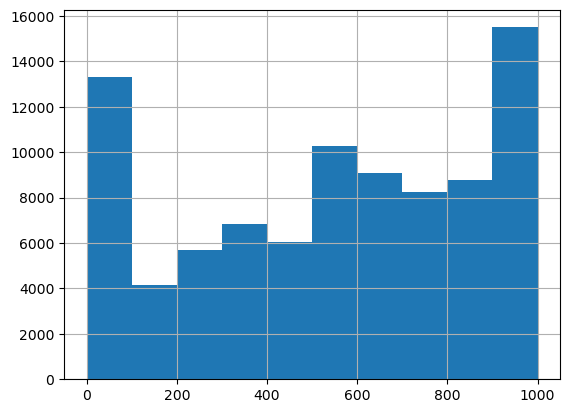

In [842]:
df[df['price'] <= 1000].price.hist()

In [843]:
# drop rows with price <= 50
df = df[df['price'] > 50]

### Vehicle Type Feature

In [844]:
df.vehicle_type.describe()

count     308520
unique         8
top        sedan
freq       89072
Name: vehicle_type, dtype: object

In [845]:
df.vehicle_type.value_counts()

vehicle_type
sedan          89072
small          77596
wagon          63452
bus            28246
convertible    19796
coupe          15547
suv            11759
other           3052
Name: count, dtype: int64

In [846]:
# replace null values with most frequent value of matching brand and model
df.vehicle_type = df.groupby(['brand', 'model'])['vehicle_type'].transform(lambda x: x.fillna(x.mode()[0]))

In [847]:
df.head()

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,NaN,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [848]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341360 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              341360 non-null  int64 
 1   vehicle_type       324250 non-null  object
 2   registration_year  341360 non-null  int64 
 3   gearbox            324814 non-null  object
 4   horsepower         341360 non-null  int64 
 5   model              324250 non-null  object
 6   mileage            341360 non-null  int64 
 7   fuel_type          312785 non-null  object
 8   brand              341360 non-null  object
 9   not_repaired       276678 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.6+ MB


### Model Feature

In [849]:
df[df['model'].isnull()].sample(20)

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
89070,1950,NaN,1995,manual,115,NaN,150000,petrol,audi,no
292330,3000,NaN,2005,auto,7,NaN,40000,gasoline,sonstige_autos,no
116989,4500,NaN,2016,NaN,0,NaN,150000,gasoline,volkswagen,yes
122963,4500,NaN,1956,manual,9,NaN,5000,petrol,sonstige_autos,NaN
37472,300,NaN,1996,NaN,0,NaN,5000,NaN,volkswagen,NaN
254811,333,NaN,2016,manual,60,NaN,150000,NaN,ford,no
155088,3950,NaN,2016,NaN,131,NaN,150000,gasoline,volkswagen,NaN
105613,11400,NaN,1988,manual,29,NaN,70000,petrol,ford,no
189122,350,NaN,1997,manual,60,NaN,150000,petrol,volkswagen,no
147591,2950,NaN,2017,auto,0,NaN,150000,NaN,smart,no


In [850]:
# drop rows with null values in model column
df = df[df['vehicle_type'].notnull()]

In [851]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324250 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              324250 non-null  int64 
 1   vehicle_type       324250 non-null  object
 2   registration_year  324250 non-null  int64 
 3   gearbox            310519 non-null  object
 4   horsepower         324250 non-null  int64 
 5   model              324250 non-null  object
 6   mileage            324250 non-null  int64 
 7   fuel_type          301289 non-null  object
 8   brand              324250 non-null  object
 9   not_repaired       266815 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.2+ MB


In [852]:
# get list of models with less than 100 entries
display(df.model.value_counts()[df.model.value_counts() < 100])

model
wrangler              99
q5                    97
kalos                 95
90                    93
citigo                91
g_klasse              91
navara                90
lanos                 86
mii                   81
discovery             78
range_rover           75
defender              74
911                   70
crossfire             64
glk                   63
cx_reihe              63
nubira                61
range_rover_sport     54
move                  51
lybra                 50
145                   45
croma                 45
v60                   42
terios                35
lodgy                 35
delta                 34
9000                  28
charade               27
b_max                 26
musa                  23
materia               18
200                   17
kappa                 14
amarok                13
q3                    13
gl                    12
samara                12
elefantino            11
kalina                 9
i3                 

In [853]:
# get percentage of other models
df[df['model'] == 'other'].shape[0] / df.shape[0]

0.07254587509637625

In [854]:
# drop other models
df = df[df['model'] != 'other']

### Year Feature

In [855]:
df.registration_year.describe()

count    300727.000000
mean       2004.070476
std          55.551118
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

<Axes: >

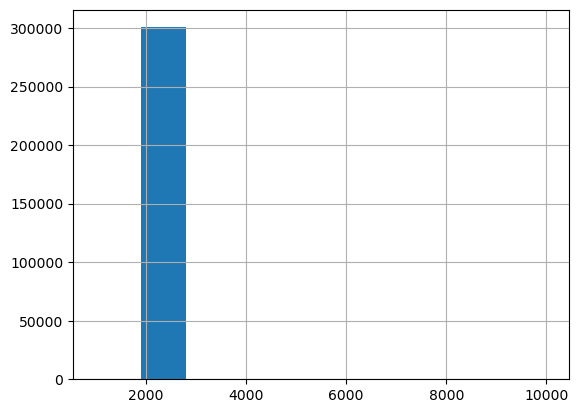

In [856]:
# plot histogram of registration year
df.registration_year.hist()

In [857]:
df[df['registration_year'] < 1950].registration_year.value_counts()

registration_year
1910    18
1000    10
1938     3
1500     2
1234     2
1923     2
1300     2
1945     1
1400     1
1936     1
1800     1
1600     1
Name: count, dtype: int64

In [858]:
display(df[df['registration_year'] <= 1900])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
16062,190,wagon,1000,NaN,0,mondeo,5000,NaN,ford,NaN
18224,7999,sedan,1500,manual,224,impreza,5000,NaN,subaru,NaN
53577,330,small,1000,NaN,0,polo,5000,NaN,volkswagen,NaN
56241,950,sedan,1400,manual,1400,golf,125000,petrol,volkswagen,NaN
71459,500,sedan,1000,NaN,0,golf,5000,NaN,volkswagen,NaN
97736,140,coupe,1000,NaN,0,911,5000,NaN,porsche,NaN
104698,100,wagon,1234,NaN,0,156,5000,petrol,alfa_romeo,NaN
121196,100,suv,1500,NaN,0,g_klasse,5000,NaN,mercedes_benz,NaN
129768,275,sedan,1234,NaN,0,e_klasse,5000,NaN,mercedes_benz,NaN
143621,550,sedan,1000,NaN,1000,golf,5000,petrol,volkswagen,NaN


In [859]:
df[df['registration_year'] > 2016].registration_year.value_counts()

registration_year
2017    8182
2018    3100
2019      15
9999       8
5000       8
7000       3
4000       3
2500       2
5555       2
5911       2
5900       1
2900       1
9000       1
8500       1
3700       1
2290       1
2066       1
3000       1
7100       1
2200       1
8200       1
Name: count, dtype: int64

In [860]:
display(df[df['registration_year'] == 2018])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
22,2900,bus,2018,manual,90,meriva,150000,petrol,opel,no
163,1200,sedan,2018,manual,75,astra,150000,NaN,opel,no
196,2800,small,2018,manual,75,twingo,125000,NaN,renault,no
355,1050,sedan,2018,NaN,0,golf,150000,NaN,volkswagen,NaN
390,3400,sedan,2018,NaN,0,astra,150000,petrol,opel,no
...,...,...,...,...,...,...,...,...,...,...
353824,2500,sedan,2018,manual,125,a_klasse,150000,petrol,mercedes_benz,no
353825,1600,small,2018,manual,0,lupo,5000,petrol,volkswagen,no
353918,999,sedan,2018,NaN,0,golf,150000,NaN,volkswagen,no
354203,2140,small,2018,manual,80,fiesta,150000,NaN,ford,no


In [861]:
# drop rows with registration year < 1900 or > 2016
df = df[df['registration_year'].between(1900, 2016)]

### Transmission Feature

In [862]:
df.gearbox.value_counts()

gearbox
manual    222948
auto       55140
Name: count, dtype: int64

In [863]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289372 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              289372 non-null  int64 
 1   vehicle_type       289372 non-null  object
 2   registration_year  289372 non-null  int64 
 3   gearbox            278088 non-null  object
 4   horsepower         289372 non-null  int64 
 5   model              289372 non-null  object
 6   mileage            289372 non-null  int64 
 7   fuel_type          272141 non-null  object
 8   brand              289372 non-null  object
 9   not_repaired       240610 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


In [864]:
df[df['gearbox'].isnull()].sample(20)

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
123353,3600,sedan,2005,NaN,0,a3,150000,gasoline,audi,NaN
136080,4500,sedan,2001,NaN,0,passat,80000,petrol,volkswagen,no
135219,1234,wagon,1995,NaN,0,caddy,10000,NaN,volkswagen,NaN
200663,260,small,2000,NaN,0,fiesta,150000,NaN,ford,NaN
146463,850,small,2002,NaN,45,fortwo,100000,petrol,smart,yes
328208,13900,sedan,2016,NaN,141,qashqai,60000,petrol,nissan,no
25941,9990,convertible,2005,NaN,150,3er,150000,lpg,bmw,NaN
52899,5000,sedan,2007,NaN,0,a3,150000,gasoline,audi,yes
189425,4900,bus,2005,NaN,0,golf,150000,gasoline,volkswagen,no
331584,3500,bus,2002,NaN,115,sharan,150000,NaN,volkswagen,no


In [865]:
display(df[df['model'] == 'other'].gearbox.value_counts())

Series([], Name: count, dtype: int64)

In [866]:
# assume that vehicles with null gearbox values are manual
df.gearbox = df.gearbox.fillna('manual')

In [867]:
df.horsepower.describe()

count    289372.000000
mean        112.848658
std         182.681370
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: horsepower, dtype: float64

In [868]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289372 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              289372 non-null  int64 
 1   vehicle_type       289372 non-null  object
 2   registration_year  289372 non-null  int64 
 3   gearbox            289372 non-null  object
 4   horsepower         289372 non-null  int64 
 5   model              289372 non-null  object
 6   mileage            289372 non-null  int64 
 7   fuel_type          272141 non-null  object
 8   brand              289372 non-null  object
 9   not_repaired       240610 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


In [869]:
df[df['horsepower'] < 20].horsepower.value_counts()

horsepower
0     25167
18       42
1        13
5        10
19        9
10        7
12        6
11        6
4         5
14        4
15        4
2         4
16        4
8         4
6         4
7         3
17        2
13        2
3         1
Name: count, dtype: int64

In [870]:
display(df[df['horsepower'] == 5])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
59478,999,convertible,1995,manual,5,punto,125000,petrol,fiat,no
78193,999,small,2000,manual,5,twingo,150000,petrol,renault,NaN
118004,6500,bus,2006,manual,5,5_reihe,150000,petrol,mazda,no
134171,1790,sedan,2002,manual,5,corsa,150000,petrol,opel,no
138316,360,small,1999,manual,5,twingo,150000,petrol,renault,NaN
146998,650,bus,1998,manual,5,kangoo,150000,petrol,renault,no
154878,500,small,2016,manual,5,lupo,150000,petrol,volkswagen,no
180367,700,small,2001,manual,5,polo,150000,petrol,volkswagen,no
186450,1990,small,2004,manual,5,fiesta,150000,petrol,ford,no
320484,1399,small,2001,manual,5,fortwo,125000,petrol,smart,no


In [871]:
df[df['horsepower'] == 0].sample(20)

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
130956,250,small,2005,manual,0,corsa,5000,petrol,opel,NaN
109985,350,convertible,1995,manual,0,3_reihe,5000,petrol,peugeot,NaN
157529,200,coupe,1998,manual,0,3er,150000,petrol,bmw,NaN
276777,3600,bus,2007,manual,0,combo,150000,gasoline,opel,no
131089,2950,convertible,1976,manual,0,kaefer,100000,NaN,volkswagen,yes
107405,1700,wagon,1999,manual,0,passat,150000,gasoline,volkswagen,no
3956,2850,bus,2003,manual,0,meriva,150000,petrol,opel,no
56893,600,wagon,1996,manual,0,golf,150000,NaN,volkswagen,NaN
208671,1500,sedan,2016,manual,0,c_klasse,125000,petrol,mercedes_benz,no
115311,200,small,2000,manual,0,corsa,150000,petrol,opel,NaN


In [872]:
# fill horsepower zero values with median non-zero horsepower of matching brand and model and year
df.horsepower = df.groupby(['brand', 'model', 'registration_year'])['horsepower'].transform(lambda x: x.replace(0, x[x > 0].median()))

# drop null horsepower values (which were zero before), then convert back to int
df.dropna(subset=['horsepower'], inplace=True)
df.horsepower = df.horsepower.astype('int')

In [873]:
df.describe()

,price,registration_year,horsepower,mileage
count,289118.000000,289118.000000,289118.000000,289118.00000
mean,4702.547918,2003.075329,121.766199,128912.31262
std,4547.312200,6.036812,179.945703,36470.86245
min,55.000000,1910.000000,1.000000,5000.00000
25%,1250.000000,1999.000000,75.000000,125000.00000
50%,2999.000000,2003.000000,110.000000,150000.00000
75%,6800.000000,2007.000000,145.000000,150000.00000
max,20000.000000,2016.000000,20000.000000,150000.00000


In [874]:
df[df['horsepower'] < 20].horsepower.value_counts()

horsepower
18    54
1     14
5     10
19     9
10     7
12     6
11     6
4      5
14     4
6      4
2      4
15     4
16     4
8      4
7      3
17     2
13     2
3      1
Name: count, dtype: int64

In [875]:
# drop rows with horsepower < 10
df = df[df['horsepower'] >= 10]

In [876]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289073 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              289073 non-null  int64 
 1   vehicle_type       289073 non-null  object
 2   registration_year  289073 non-null  int64 
 3   gearbox            289073 non-null  object
 4   horsepower         289073 non-null  int64 
 5   model              289073 non-null  object
 6   mileage            289073 non-null  int64 
 7   fuel_type          271968 non-null  object
 8   brand              289073 non-null  object
 9   not_repaired       240478 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


In [877]:
display(df[df['horsepower'] > 600])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
6296,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,NaN
...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,NaN
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN


In [878]:
# if horsepower > 600, replace with median horsepower of matching brand and model
df.horsepower = df.groupby(['brand', 'model'])['horsepower'].transform(lambda x: x.replace(x[x > 600].median()))

In [879]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289073 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              289073 non-null  int64 
 1   vehicle_type       289073 non-null  object
 2   registration_year  289073 non-null  int64 
 3   gearbox            289073 non-null  object
 4   horsepower         289073 non-null  int64 
 5   model              289073 non-null  object
 6   mileage            289073 non-null  int64 
 7   fuel_type          271968 non-null  object
 8   brand              289073 non-null  object
 9   not_repaired       240478 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


In [880]:
display(df[df['horsepower'] > 600])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,NaN
6504,3000,small,2009,manual,771,punto,125000,petrol,fiat,NaN
6637,600,small,1996,manual,603,corsa,150000,petrol,opel,yes
7661,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,NaN
8057,500,small,2002,manual,620,ypsilon,150000,petrol,lancia,NaN
...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,NaN
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353633,2400,sedan,2007,manual,650,c2,150000,petrol,citroen,NaN


In [881]:
# drop rows with horsepower > 600
df = df[df['horsepower'] <= 600]

In [882]:
df.horsepower.describe()

count    288879.000000
mean        118.543806
std          52.089662
min          10.000000
25%          75.000000
50%         110.000000
75%         145.000000
max         600.000000
Name: horsepower, dtype: float64

In [883]:
df.fuel_type.value_counts()

fuel_type
petrol      180558
gasoline     86474
lpg           4076
cng            472
hybrid         123
other           85
electric        25
Name: count, dtype: int64

In [884]:
display(df[df['fuel_type'].isnull()])

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
13,2500,wagon,2004,manual,131,passat,150000,NaN,volkswagen,no
36,1600,other,1991,manual,75,kadett,70000,NaN,opel,NaN
41,7500,sedan,2002,auto,306,e_klasse,150000,NaN,mercedes_benz,NaN
54,4700,wagon,2005,manual,155,signum,150000,NaN,opel,no
...,...,...,...,...,...,...,...,...,...,...
354327,2999,wagon,2004,manual,234,vectra,100000,NaN,opel,NaN
354329,350,small,1996,manual,65,punto,150000,NaN,fiat,NaN
354339,3850,convertible,2006,manual,108,2_reihe,125000,NaN,peugeot,no
354346,2600,sedan,2005,auto,150,c_klasse,150000,NaN,mercedes_benz,NaN


In [885]:
# replace gasoline with petrol
df.fuel_type = df.fuel_type.replace('gasoline', 'petrol')

In [886]:
# replace null values in fuel type with most frequent value of matching brand and model
df.fuel_type = df.groupby(['brand', 'model'])['fuel_type'].transform(lambda x: x.fillna(x.mode()[0]))

In [887]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288879 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              288879 non-null  int64 
 1   vehicle_type       288879 non-null  object
 2   registration_year  288879 non-null  int64 
 3   gearbox            288879 non-null  object
 4   horsepower         288879 non-null  int64 
 5   model              288879 non-null  object
 6   mileage            288879 non-null  int64 
 7   fuel_type          288879 non-null  object
 8   brand              288879 non-null  object
 9   not_repaired       240363 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.2+ MB


In [888]:
df.not_repaired.value_counts()

not_repaired
no     212564
yes     27799
Name: count, dtype: int64

In [889]:
df.not_repaired = df.not_repaired.fillna('no')

In [890]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288879 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              288879 non-null  int64 
 1   vehicle_type       288879 non-null  object
 2   registration_year  288879 non-null  int64 
 3   gearbox            288879 non-null  object
 4   horsepower         288879 non-null  int64 
 5   model              288879 non-null  object
 6   mileage            288879 non-null  int64 
 7   fuel_type          288879 non-null  object
 8   brand              288879 non-null  object
 9   not_repaired       288879 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.2+ MB


In [891]:
# show the sorted unique values of the model column
df.model.sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [892]:
%%time
# show number of other models
print(df[df['model'] == 'other'].model.count())

0
CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 10.3 ms


In [893]:
# remove other models
df = df[df['model'] != 'other']

In [894]:
df.brand.sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo'],
      dtype=object)

In [895]:
# reset index
df.reset_index(drop=True, inplace=True)

In [896]:
df.mileage.describe()

count    288879.000000
mean     128915.116710
std       36463.602656
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: mileage, dtype: float64

<Axes: >

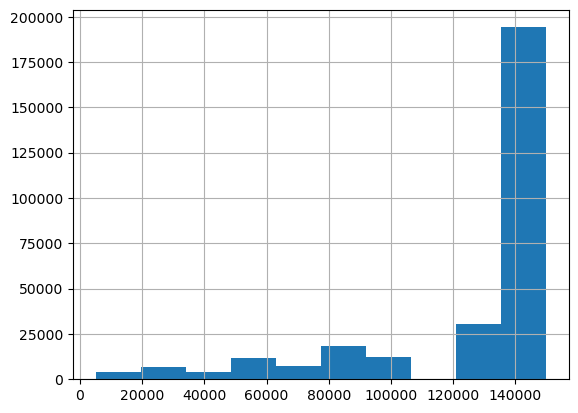

In [897]:
df.mileage.hist()

In [898]:
df.mileage.value_counts()

mileage
150000    194168
125000     30545
100000     12193
90000       9823
80000       8498
70000       7284
60000       6374
50000       5263
40000       4167
30000       3606
5000        3145
20000       3015
10000        798
Name: count, dtype: int64

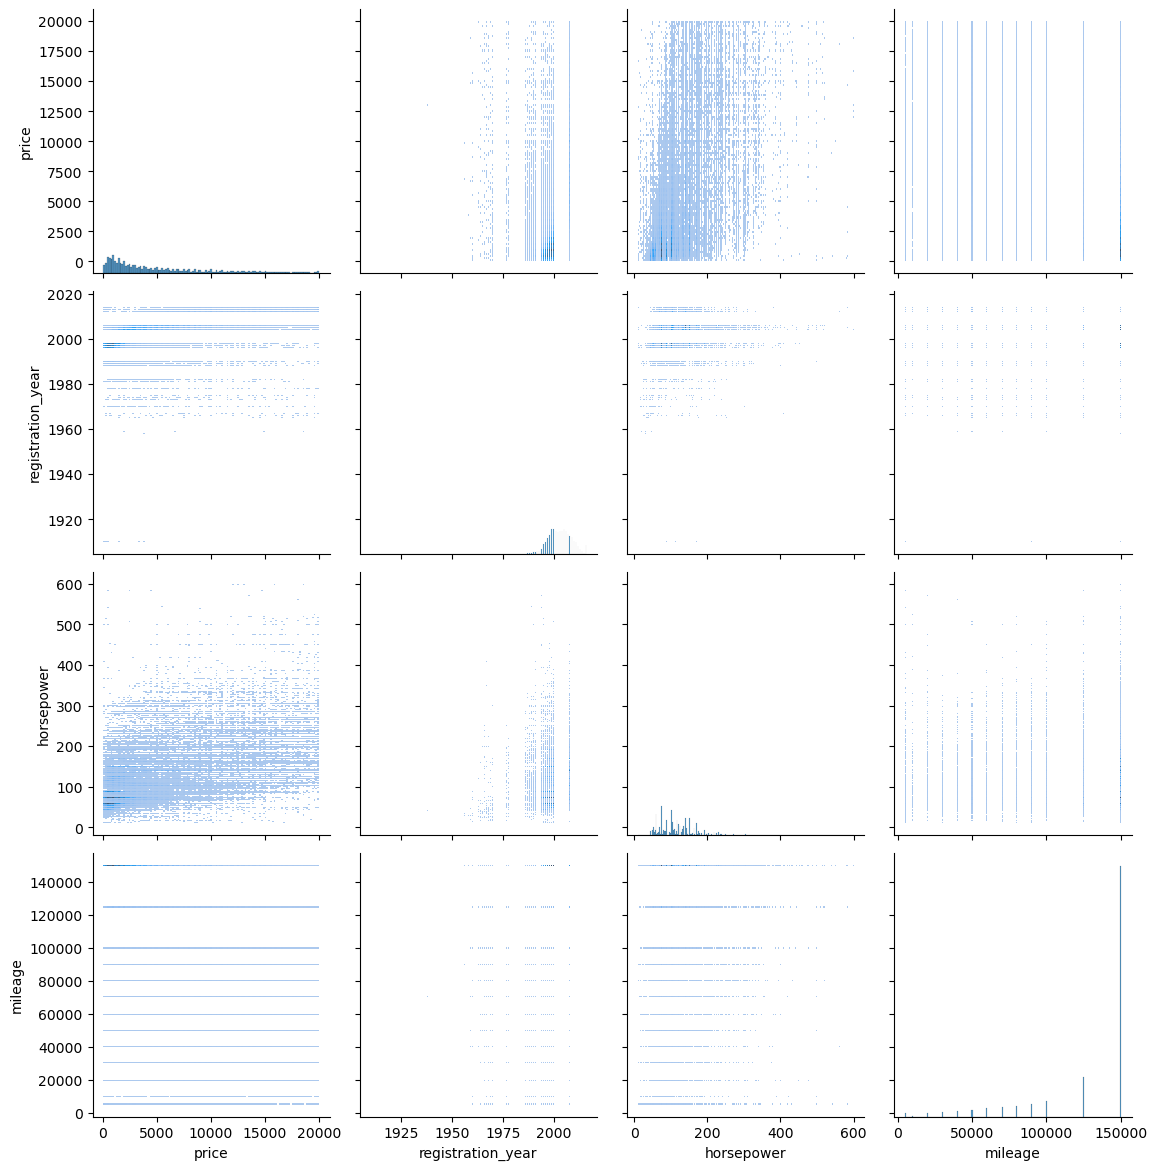

In [899]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12,12)

## Creating the models

In [900]:
random_state = 12345

In [925]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288879 entries, 0 to 288878
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              288879 non-null  int64 
 1   vehicle_type       288879 non-null  object
 2   registration_year  288879 non-null  int64 
 3   gearbox            288879 non-null  object
 4   horsepower         288879 non-null  int64 
 5   model              288879 non-null  object
 6   mileage            288879 non-null  int64 
 7   fuel_type          288879 non-null  object
 8   brand              288879 non-null  object
 9   not_repaired       288879 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.0+ MB


In [924]:
df.sample(10)

,price,vehicle_type,registration_year,gearbox,horsepower,model,mileage,fuel_type,brand,not_repaired
4750,1000,small,2001,manual,60,micra,150000,petrol,nissan,no
120683,100,small,1994,manual,74,golf,150000,petrol,volkswagen,yes
88851,10799,sedan,2010,manual,116,1er,150000,petrol,bmw,no
110445,400,wagon,1999,manual,131,mondeo,150000,petrol,ford,no
102430,1800,sedan,1995,manual,136,e_klasse,150000,lpg,mercedes_benz,no
95796,15999,sedan,2009,manual,204,c_klasse,90000,petrol,mercedes_benz,no
279753,1200,small,2000,manual,58,corsa,150000,petrol,opel,no
78467,3990,sedan,2005,manual,109,focus,125000,petrol,ford,no
257263,1300,small,1999,auto,54,micra,125000,petrol,nissan,no
179104,10900,sedan,2008,manual,177,1er,150000,petrol,bmw,no


In [926]:
# split data into features and target (price)
features = df.drop('price', axis=1)
target = df.price

In [929]:
# Split data into training, validation, and test sets (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    features, target, test_size=0.4, random_state=random_state
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=random_state
)

# Print the sizes of the datasets
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_valid.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')
print(f'Target training set size: {y_train.shape[0]}')
print(f'Target validation set size: {y_valid.shape[0]}')
print(f'Target test set size: {y_test.shape[0]}')
print(f'Total: {X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]}')

Training set size: 173327
Validation set size: 57776
Test set size: 57776
Target training set size: 173327
Target validation set size: 57776
Target test set size: 57776
Total: 288879


In [933]:
# create lists of numeric and categorical features
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
numeric_features = ['registration_year', 'mileage', 'horsepower']

In [934]:
# create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# create pipeline for numeric features
numeric_transformer = 'passthrough'

# create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ])



### Linear Regression

In [938]:
%%timeit -o -r 1 -n 1 -q
# create the linear regression model
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# fit the model to the training data
model_lr.fit(X_train, y_train)

# make predictions on the validation set and score using RMSE
y_pred_lr = model_lr.predict(X_valid)
rmse_lr = mean_squared_error(y_valid, y_pred_lr, squared=False)
print(f'Linear Regression RMSE: {rmse_lr}')

time_lr = _

Linear Regression RMSE: 2737.4193146204693


<TimeitResult : 264 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [ ]:
# Define the hyperparameters to tune
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_split': [2, 4, 6, 8],
    'regressor__min_samples_leaf': [1, 2, 3, 4]
}

### Random Forest

In [944]:
%%timeit -o -r 1 -n 1 -q

# create the random forest model
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=random_state))
])

# Define the hyperparameters to tune
param_grid = {
    'regressor__n_estimators': [100, 150, 200, 250, 300],
    'regressor__max_depth': [5, 10, 15, 20]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(model_rf, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params_rf = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best Random Forest hyperparameters: {best_params_rf}')
y_pred_rf = best_rf_model.predict(X_valid)
rmse_rf = mean_squared_error(y_valid, y_pred_rf, squared=False)
print(f'Random Forest RMSE: {rmse_rf}')

time_rf = _


Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

### Decision Tree

In [ ]:
%%timeit -o -r 1 -n 1 -q

# create the decision tree model
model_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=random_state))
])

# Define the hyperparameters to tune
param_grid = {
    'regressor__max_depth': [10, 20, 30],
    'regressor__min_samples_split': [2, 4, 6, 8],
    'regressor__min_samples_leaf': [1, 2, 3, 4]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(model_dt, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params_dt = grid_search.best_params_
best_dt_model = grid_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best Decision Tree hyperparameters: {best_params_rf}')
y_pred_rf = best_dt_model.predict(X_valid)
rmse_dt = mean_squared_error(y_valid, y_pred_dt, squared=False)
print(f'Random Forest RMSE: {rmse_dt}')

time_dt = _

### LightGBM

In [ ]:
model_lgbm = LGBMRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 1],
    'max_depth': [5, 10, -1],
    'num_leaves': [10, 20, 30, 50],
    'min_child_samples': [20, 50, 100]
}

grid_search = GridSearchCV(model_lgbm, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params_lgbm = grid_search.best_params_
best_lgbm_model = grid_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best Decision Tree hyperparameters: {best_params_lgbm}')
y_pred_lgbm = best_lgbm_model.predict(X_valid)
rmse_lgbm = mean_squared_error(y_valid, y_pred_lgbm, squared=False)
print(f'Random Forest RMSE: {rmse_lgbm}')

time_lgbm = _

### XGBoost

In [ ]:
# create the xgboost model
model_xgb = XGBRegressor(random_state=random_state)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 1],
    'max_depth': [5, 10, -1],
    'min_child_weight': [1, 5, 10]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(model_xgb, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params_xgb = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best XGBoost hyperparameters: {best_params_xgb}')
y_pred_xgb = best_xgb_model.predict(X_valid)
rmse_xgb = mean_squared_error(y_valid, y_pred_xgb, squared=False)
print(f'XGBoost RMSE: {rmse_xgb}')

time_xgb = _

### CatBoost


In [ ]:
%%timeit -o -r 1 -n 1 -q

# create the catboost model
model_cat = CatBoostRegressor(random_state=random_state, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 1],
    'depth': [5, 10, -1],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(model_cat, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# get the best hyperparameters
best_params_cat = grid_search.best_params_
best_cat_model = grid_search.best_estimator_

# make predictions on the validation set and score using RMSE
print(f'Best CatBoost hyperparameters: {best_params_cat}')
y_pred_cat = best_cat_model.predict(X_valid)
rmse_cat = mean_squared_error(y_valid, y_pred_cat, squared=False)
print(f'CatBoost RMSE: {rmse_cat}')

time_cat = _

### Model Evaluation

### Applying the model to the test data

## Conclusion